In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
import kagglehub
import shutil
from pathlib import Path

# Step 1: Download the latest version of the dataset
path = kagglehub.dataset_download("saumyaagrawal1709/opencode-dataset")
print("Path to dataset files:", path)

# Step 2: Define paths for the downloaded dataset and reorganized dataset
# Adjusting to match the observed structure
source_root = Path(path) / "Pest and Disease/Dataset"  # Adjust this dynamically if needed
organized_root = Path("./Dataset")
train_dir = organized_root / "train"
test_dir = organized_root / "test"

# Create the directories for train and test if they don't exist
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Check if source_root exists
if not source_root.exists():
    print("Contents of the dataset directory:")
    for root, dirs, files in os.walk(Path(path)):
        print(f"Directory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files}")
        print("-" * 40)
    raise FileNotFoundError(f"Source directory not found: {source_root}")

# Step 3: Reorganize the dataset
def reorganize_dataset(source_root, train_dir, test_dir):
    for crop in source_root.iterdir():
        if crop.is_dir():  # Crop directories: Cashew, Cassava, Maize, Tomato
            print(f"Processing crop: {crop.name}")
            for subset in ["train_set", "test_set"]:
                subset_dir = crop / subset
                if subset_dir.exists():
                    print(f"  Found subset: {subset}")
                    for class_dir in subset_dir.iterdir():
                        if class_dir.is_dir():  # Class folders (e.g., anthracnose, healthy)
                            new_class_name = f"{class_dir.name}_{crop.name.lower()}"
                            target_subdir = train_dir if subset == "train_set" else test_dir
                            target_class_dir = target_subdir / new_class_name
                            target_class_dir.mkdir(parents=True, exist_ok=True)

                            for file in class_dir.iterdir():
                                if file.is_file():
                                    try:
                                        shutil.move(str(file), str(target_class_dir))
                                    except Exception as e:
                                        print(f"Error moving file {file}: {e}")
    print("Reorganization complete. Verifying files...")

    # Verify dataset structure
    for subset, subset_dir in [("train", train_dir), ("test", test_dir)]:
        print(f"{subset.capitalize()} set:")
        for class_dir in subset_dir.iterdir():
            if class_dir.is_dir():
                print(f"  {class_dir.name}: {len(list(class_dir.iterdir()))} files")

# Run the reorganization
reorganize_dataset(source_root, train_dir, test_dir)
print("Dataset reorganized successfully!")

100%|██████████| 6.26G/6.26G [01:13<00:00, 91.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saumyaagrawal1709/opencode-dataset/versions/2
Processing crop: Cashew
  Found subset: train_set
  Found subset: test_set
Processing crop: Tomato
  Found subset: train_set
  Found subset: test_set
Processing crop: Cassava
  Found subset: train_set
  Found subset: test_set
Processing crop: Maize
  Found subset: train_set
  Found subset: test_set
Reorganization complete. Verifying files...
Train set:
  mosaic_cassava: 2250 files
  brown spot_cassava: 3250 files
  healthy_tomato: 2000 files
  fall armyworm_maize: 1140 files
  bacterial blight_cassava: 3241 files
  healthy_cashew: 5877 files
  septoria leaf spot_tomato: 9373 files
  red rust_cashew: 4751 files
  verticulium wilt_tomato: 3100 files
  green mite_cassava: 3246 files
  leaf curl_tomato: 2050 files
  gumosis_cashew: 1714 files
  leaf spot_maize: 3024 files
  grasshoper_maize: 2575 files
  leaf blight_maize: 4025 files
  leaf miner_cashew: 3466 files
  streak virus_maize: 404

In [3]:
train_data = ImageDataGenerator(rescale=1.0/255)
test_data = ImageDataGenerator(rescale=1.0/255)


train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_data.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print("Classes found in the dataset:", train_generator.class_indices)

# Do not change this code

Found 74317 images belonging to 22 classes.
Found 24981 images belonging to 22 classes.
Classes found in the dataset: {'anthracnose_cashew': 0, 'bacterial blight_cassava': 1, 'brown spot_cassava': 2, 'fall armyworm_maize': 3, 'grasshoper_maize': 4, 'green mite_cassava': 5, 'gumosis_cashew': 6, 'healthy_cashew': 7, 'healthy_cassava': 8, 'healthy_maize': 9, 'healthy_tomato': 10, 'leaf beetle_maize': 11, 'leaf blight_maize': 12, 'leaf blight_tomato': 13, 'leaf curl_tomato': 14, 'leaf miner_cashew': 15, 'leaf spot_maize': 16, 'mosaic_cassava': 17, 'red rust_cashew': 18, 'septoria leaf spot_tomato': 19, 'streak virus_maize': 20, 'verticulium wilt_tomato': 21}


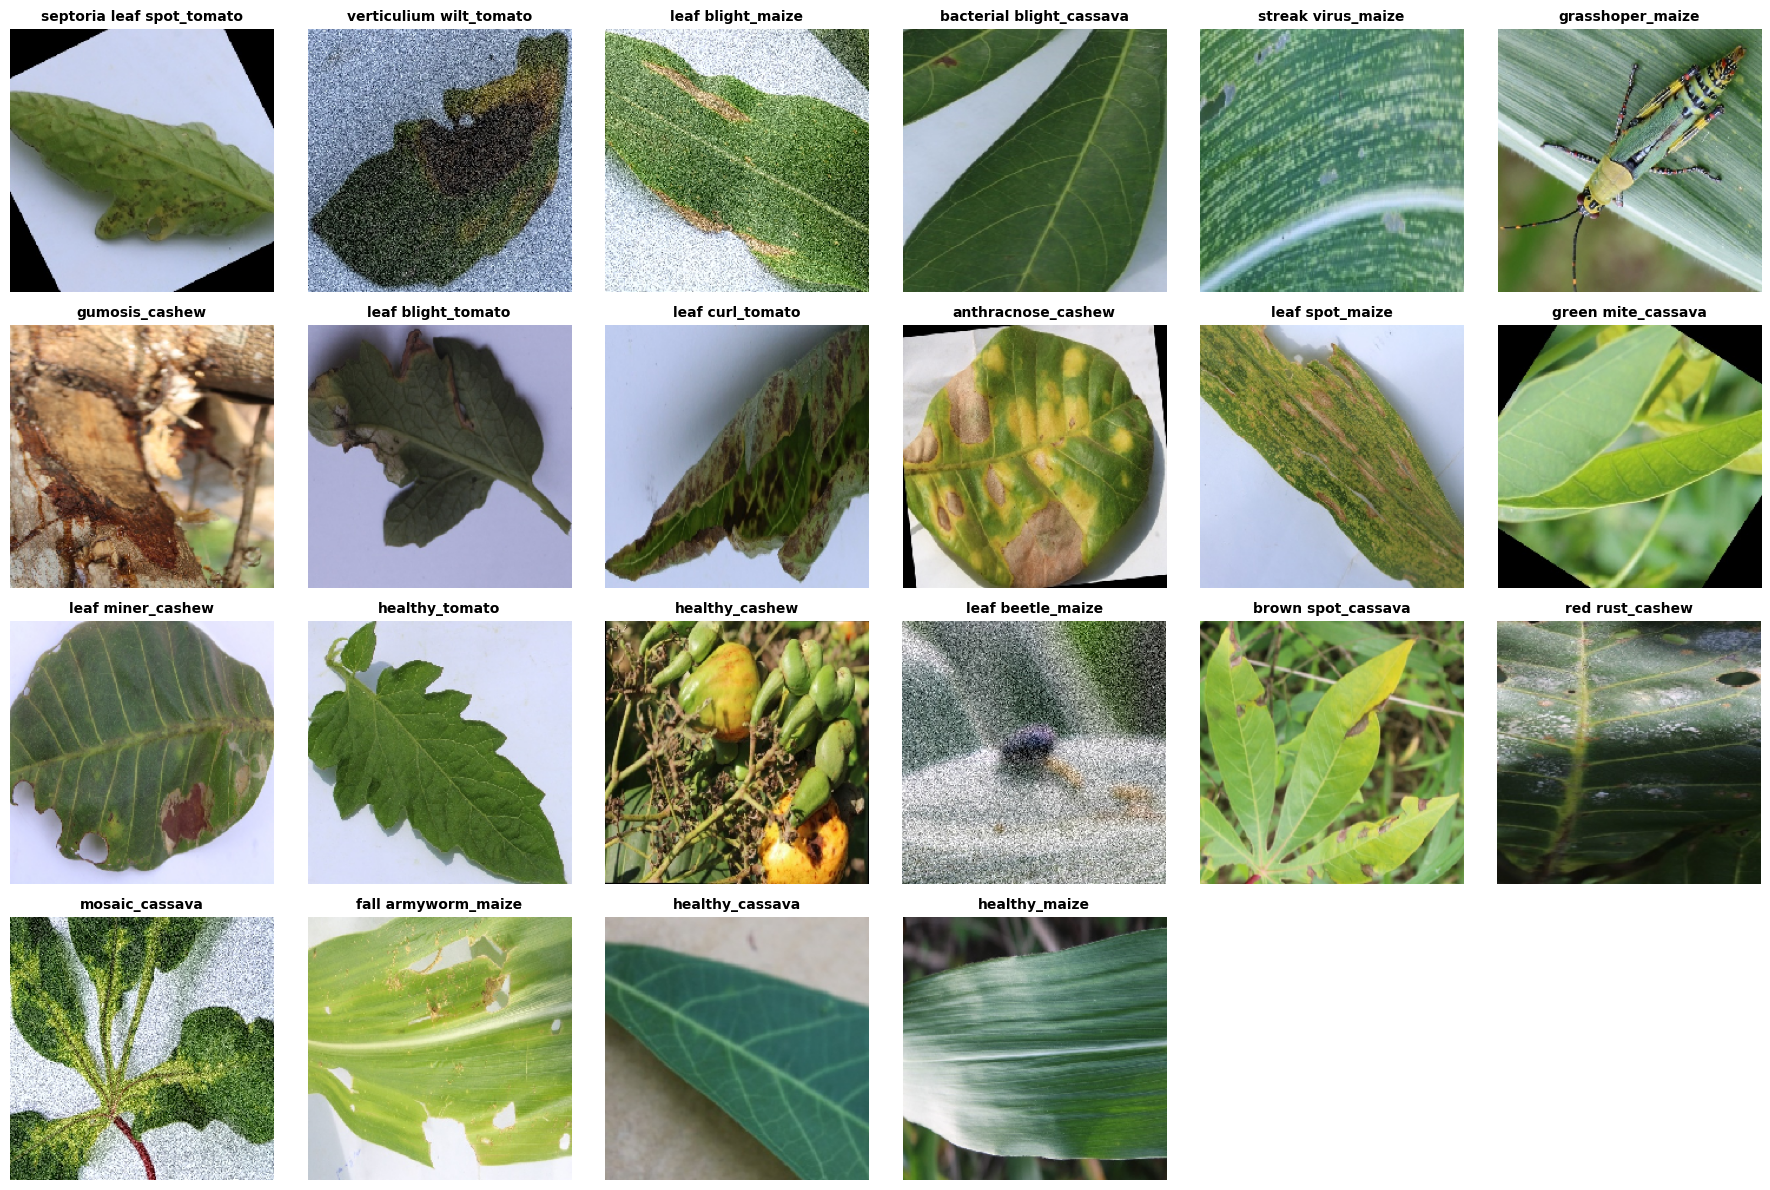

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve class indices and initialize a tracker for shown classes
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
classes_shown = {class_name: False for class_name in class_names}

# Function to visualize a batch of images in a grid layout
def display_images_grid(images, labels, num_columns=4):
    num_images = len(images)
    num_rows = (num_images + num_columns - 1) // num_columns  # Calculate rows needed
    plt.figure(figsize=(num_columns * 3, num_rows * 3))  # Reduce figure size for smaller images

    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(image)
        plt.title(f"{label}", fontsize=10, fontweight='bold')  # Slightly smaller title font
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Store images and their corresponding labels for grid display
images_to_display = []
labels_to_display = []

# Loop through batches and collect one image per class
for batch_images, batch_labels in train_generator:
    for idx in range(batch_images.shape[0]):
        # Determine the class label for the current image
        label_idx = np.argmax(batch_labels[idx])
        class_label = class_names[label_idx]

        # Collect the image and label if not already displayed
        if not classes_shown[class_label]:
            images_to_display.append(batch_images[idx])
            labels_to_display.append(class_label)
            classes_shown[class_label] = True

        # Stop collecting once all classes are covered
        if all(classes_shown.values()):
            break

    # Exit the outer loop once all classes are covered
    if all(classes_shown.values()):
        break

# Display collected images in a grid layout
display_images_grid(images_to_display, labels_to_display, num_columns=6)
